# Financial News Sentiment Analysis

### Description

This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis >Financial Sentiment Analysis</a>. The dataset is under public domain license (v10.0).

---
### Table of contents

1. [Dataset](#dataset)
2. [Data preparation](#preparation)
3. [Classification](#classification)
   1. [Simple Conv](#)
   2. [LSTM](#)
   3. [GRU](#)
   4. [Bidirectional](#)
   5. [Conv1d](#)
   6. [FinBERT](#finbert)
4. [Model Comparison](#comparison)

---
## 1. Dataset

In [100]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score,recall_score,precision_score
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras import layers
from scipy import stats
import warnings
import sys

In [52]:
df = pd.read_csv("data//data.csv")

In [53]:
print(df)

                                               Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


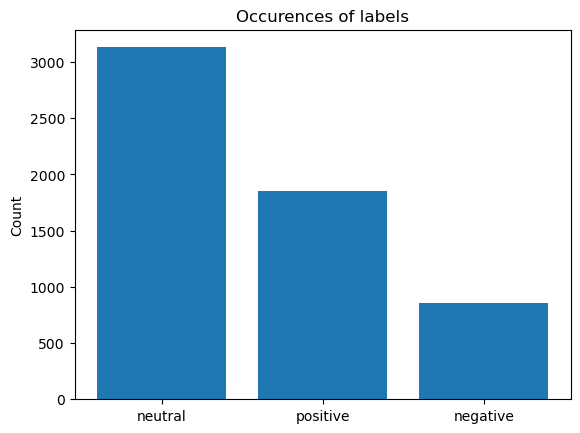

In [54]:
fig,ax = plt.subplots()
ax.bar(df["Sentiment"].value_counts().index,df["Sentiment"].value_counts().values)
ax.set_ylabel("Count")
ax.set_title("Occurences of labels")
print(df["Sentiment"].value_counts())

Dataset is **imbalanced**: almost 2x positive label than negative and 2x neutral label than positive.

**Solution**: use imblearn RandomOverSampler. (Under-sampling would make dataset insufficiently small)

## 2. Data Preparation

In [55]:
encoder = LabelEncoder()
encoder.fit(df["Sentiment"])

LabelEncoder()

In [56]:
X = df["Sentence"]
y = encoder.transform(df["Sentiment"])

In [140]:
print(encoder.classes_)

['negative' 'neutral' 'positive']


In [57]:
print(y)

[2 0 2 ... 1 1 2]


In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [59]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4673,) (1169,) (4673,) (1169,)


In [60]:
sampler = RandomOverSampler(random_state=42)
X_over, y_over = sampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.reshape(-1, 1))

In [61]:
y_train = np.asarray(y_over).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [62]:
print(X_over.shape,y_over.shape)

(7440, 1) (7440,)


In [63]:
avg_words=round(sum([len(i.split()) for i in X_train])/len(X_train))

In [64]:
text_vectorizer = TextVectorization(max_tokens=10000,
                                    output_mode="int",
                                    output_sequence_length=avg_words)
text_vectorizer.adapt(X_train)

In [65]:
embedding = layers.Embedding(input_dim=10000, 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length=avg_words, 
                             name="embedding_1")

## 3. Classification

### 3.1 Simple Keras CNN

In [66]:
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(3, activation='softmax')(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1,280,387
Trainable params: 1,280,387
N

In [68]:
model_1_history = model_1.fit(X_over, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_over,
                              epochs=10)

Epoch 1/10
233/233 [==============================] - 2s 8ms/step - loss: 0.9920 - accuracy: 0.5905
Epoch 2/10
233/233 [==============================] - 2s 8ms/step - loss: 0.6640 - accuracy: 0.7960
Epoch 3/10
233/233 [==============================] - 2s 9ms/step - loss: 0.4363 - accuracy: 0.8724
Epoch 4/10
233/233 [==============================] - 2s 9ms/step - loss: 0.3186 - accuracy: 0.9090
Epoch 5/10
233/233 [==============================] - 2s 9ms/step - loss: 0.2542 - accuracy: 0.9290
Epoch 6/10
233/233 [==============================] - 2s 9ms/step - loss: 0.2145 - accuracy: 0.9364
Epoch 7/10
233/233 [==============================] - 2s 8ms/step - loss: 0.1883 - accuracy: 0.9430
Epoch 8/10
233/233 [==============================] - 2s 8ms/step - loss: 0.1698 - accuracy: 0.9477
Epoch 9/10
233/233 [==============================] - 2s 8ms/step - loss: 0.1589 - accuracy: 0.9493
Epoch 10/10
233/233 [==============================] - 2s 9ms/step - loss: 0.1493 - accuracy: 0.9497

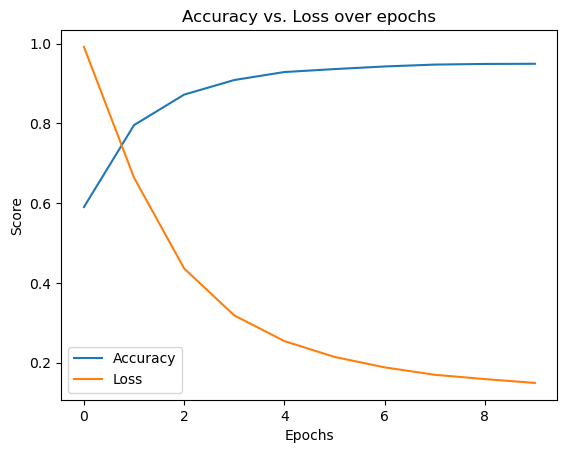

In [69]:
plt.plot(model_1_history.history["accuracy"],label="Accuracy")
plt.plot(model_1_history.history["loss"],label="Loss")
plt.title("Accuracy vs. Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

In [70]:
y_pred_cnn_vector = model_1.predict(X_test)

37/37 [==============================] - 0s 2ms/step


In [71]:
y_pred_cnn = []
for pred in y_pred_cnn_vector:
    if max(pred) ==pred[0]:
        y_pred_cnn.append(0)
    elif max(pred) ==pred[1]:
        y_pred_cnn.append(1)
    else:
        y_pred_cnn.append(2)

In [72]:
def get_scores(y_hat,y_true,model_name="model"):
    return {
        "model":model_name,
        "f1":f1_score(y_hat,y_true,average="weighted"),
        "accuracy":accuracy_score(y_hat,y_true),
        "recall": recall_score(y_hat,y_true,average="weighted"),
        "precision":precision_score(y_hat,y_true,average="weighted")
    }

In [73]:
print(get_scores(y_pred_cnn,y_test,"conv1d"))

{'model': 'conv1d', 'f1': 0.6561582122846894, 'accuracy': 0.6586826347305389, 'recall': 0.6586826347305389, 'precision': 0.656805945263283}


#### LSTM model

In [80]:
embedding_layer = layers.Embedding(input_dim=10000,
                                   output_dim=128,
                                   embeddings_initializer="uniform",
                                   input_length=avg_words,
                                   name="embedding1")
inputs = layers.Input(shape=(1,),dtype="string")

x = text_vectorizer(inputs)
x= embedding_layer(x)
x = layers.LSTM(units=64)(x)
outputs = layers.Dense(3, activation="softmax")(x)

lstm_model = tf.keras.Model(inputs,outputs,name="lstm_model")

lstm_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [81]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding1 (Embedding)      (None, 21, 128)           1280000   
                                                                 
 lstm_18 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,329,603
Trainable params: 1,329,603
Non-trainable params: 0
______________________________________________

In [82]:
lstm_history = lstm_model.fit(X_over,y_over,epochs=10)

Epoch 1/10
233/233 [==============================] - 7s 22ms/step - loss: 0.7782 - accuracy: 0.6384
Epoch 2/10
233/233 [==============================] - 5s 21ms/step - loss: 0.3188 - accuracy: 0.8863
Epoch 3/10
233/233 [==============================] - 5s 21ms/step - loss: 0.2145 - accuracy: 0.9281
Epoch 4/10
233/233 [==============================] - 6s 27ms/step - loss: 0.1733 - accuracy: 0.9394
Epoch 5/10
233/233 [==============================] - 5s 22ms/step - loss: 0.1594 - accuracy: 0.9450
Epoch 6/10
233/233 [==============================] - 5s 21ms/step - loss: 0.1461 - accuracy: 0.9478
Epoch 7/10
233/233 [==============================] - 5s 22ms/step - loss: 0.1412 - accuracy: 0.9484
Epoch 8/10
233/233 [==============================] - 5s 21ms/step - loss: 0.1250 - accuracy: 0.9507
Epoch 9/10
233/233 [==============================] - 5s 23ms/step - loss: 0.1217 - accuracy: 0.9520
Epoch 10/10
233/233 [==============================] - 7s 32ms/step - loss: 0.1213 - accura

In [ ]:
lstm_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 6ms/step - loss: 1.8381 - accuracy: 0.6193


[1.83811616897583, 0.6193327903747559]

#### GRU estimator

In [85]:
embedding_layer3 = layers.Embedding(input_dim=10000,
                                          output_dim =128,
                                          embeddings_initializer = "uniform",
                                          input_length=avg_words,
                                          name="embedding3")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer3(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(3, activation="softmax")(x)

gru_model = tf.keras.Model(inputs,outputs,name="gru_model")

gru_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics=["accuracy"]
                  )

In [87]:
gru_history  = gru_model.fit(X_over,y_over,epochs=10)

Epoch 1/10
233/233 [==============================] - 5s 23ms/step - loss: 0.4478 - accuracy: 0.8325
Epoch 2/10
233/233 [==============================] - 6s 25ms/step - loss: 0.2134 - accuracy: 0.9238
Epoch 3/10
233/233 [==============================] - 6s 25ms/step - loss: 0.1672 - accuracy: 0.9391
Epoch 4/10
233/233 [==============================] - 7s 30ms/step - loss: 0.1560 - accuracy: 0.9437
Epoch 5/10
233/233 [==============================] - 6s 25ms/step - loss: 0.1449 - accuracy: 0.9470
Epoch 6/10
233/233 [==============================] - 5s 23ms/step - loss: 0.1338 - accuracy: 0.9511
Epoch 7/10
233/233 [==============================] - 6s 24ms/step - loss: 0.1316 - accuracy: 0.9508
Epoch 8/10
233/233 [==============================] - 6s 24ms/step - loss: 0.1268 - accuracy: 0.9515
Epoch 9/10
233/233 [==============================] - 5s 22ms/step - loss: 0.1259 - accuracy: 0.9515
Epoch 10/10
233/233 [==============================] - 6s 24ms/step - loss: 0.1191 - accura

In [88]:
gru_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 8ms/step - loss: 1.9854 - accuracy: 0.6441


[1.9854001998901367, 0.6441403031349182]

#### Bidirectional

In [89]:
embedding_layer4 = layers.Embedding(input_dim=10000,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=avg_words,
                                    name="embedding4")

inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer4(x)
x = layers.Bidirectional(layers.LSTM(64,))(x)
outputs = layers.Dense(3,activation="softmax")(x)

bdir_model = tf.keras.Model(inputs,outputs,name="bdir_model")
bdir_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ["accuracy"])

In [91]:
bdir_history = bdir_model.fit(X_over,y_over,epochs=10)

Epoch 1/10
233/233 [==============================] - 8s 34ms/step - loss: 0.6604 - accuracy: 0.7179
Epoch 2/10
233/233 [==============================] - 8s 36ms/step - loss: 0.2623 - accuracy: 0.9044
Epoch 3/10
233/233 [==============================] - 7s 29ms/step - loss: 0.1751 - accuracy: 0.9387
Epoch 4/10
233/233 [==============================] - 7s 28ms/step - loss: 0.1472 - accuracy: 0.9456
Epoch 5/10
233/233 [==============================] - 9s 40ms/step - loss: 0.1408 - accuracy: 0.9473
Epoch 6/10
233/233 [==============================] - 8s 36ms/step - loss: 0.1326 - accuracy: 0.9500
Epoch 7/10
233/233 [==============================] - 7s 29ms/step - loss: 0.1371 - accuracy: 0.9476
Epoch 8/10
233/233 [==============================] - 7s 31ms/step - loss: 0.1212 - accuracy: 0.9527
Epoch 9/10
233/233 [==============================] - 7s 29ms/step - loss: 0.1163 - accuracy: 0.9543
Epoch 10/10
233/233 [==============================] - 7s 28ms/step - loss: 0.1193 - accura

In [92]:
bdir_model.evaluate(X_test,y_test)

37/37 [==============================] - 1s 8ms/step - loss: 1.9405 - accuracy: 0.6151


[1.940460205078125, 0.6150556206703186]

#### Conv1d

In [93]:
embedding_layer5 = layers.Embedding(input_dim=10000,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=avg_words,
                                    name="embedding5")

inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer5(x)

x = layers.Conv1D(filters=32,kernel_size=5,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(3,activation="softmax")(x)

conv1d_model = tf.keras.Model(inputs,outputs,name="conv1d_model")
conv1d_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ["accuracy"])

In [95]:
conv1d_history = conv1d_model.fit(X_over,y_over,epochs=10)

Epoch 1/10
233/233 [==============================] - 3s 11ms/step - loss: 0.4134 - accuracy: 0.8620
Epoch 2/10
233/233 [==============================] - 4s 16ms/step - loss: 0.2160 - accuracy: 0.9254
Epoch 3/10
233/233 [==============================] - 3s 14ms/step - loss: 0.1664 - accuracy: 0.9390
Epoch 4/10
233/233 [==============================] - 3s 12ms/step - loss: 0.1520 - accuracy: 0.9427
Epoch 5/10
233/233 [==============================] - 2s 10ms/step - loss: 0.1435 - accuracy: 0.9445
Epoch 6/10
233/233 [==============================] - 2s 10ms/step - loss: 0.1389 - accuracy: 0.9456
Epoch 7/10
233/233 [==============================] - 2s 9ms/step - loss: 0.1352 - accuracy: 0.9476
Epoch 8/10
233/233 [==============================] - 2s 9ms/step - loss: 0.1338 - accuracy: 0.9487
Epoch 9/10
233/233 [==============================] - 2s 9ms/step - loss: 0.1311 - accuracy: 0.9497
Epoch 10/10
233/233 [==============================] - 2s 9ms/step - loss: 0.1302 - accuracy: 

In [96]:
conv1d_model.evaluate(X_test,y_test)

37/37 [==============================] - 0s 2ms/step - loss: 1.3225 - accuracy: 0.6450


[1.3224947452545166, 0.6449957489967346]

#### FinBERT (hugging-face)

In [127]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = TFAutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
print(X_over.flatten())

['Peer Peugeot fell 0.81 pct as its sales rose only 6.3 pct from the same period last year .'
 'The proposal that the Board of Directors will make at the Annual General Meeting is attached as a whole to this release .'
 'Tesla is recalling 2,700 Model X cars: https://t.co/8Z7BkVsTl9 $TSLA'
 ... '$FB trending nicely, intraday.'
 '$IBIO  up 10% in premarket ready for lift off'
 '$NFLX VISION : short term consolidation then movement higher http://stks.co/j05uu']


In [138]:
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

results = nlp(X_test.tolist())

In [141]:
print(results[:10])
# pos:2
# neg:0
# neu:1
y_pred_finbert =[]
for result in results:
    if result["label"] =="negative":
        y_pred_finbert.append(0)
    elif result["label"] =="neutral":
        y_pred_finbert.append(1)
    else:
        y_pred_finbert.append(2)

[{'label': 'negative', 'score': 0.6489782333374023}, {'label': 'negative', 'score': 0.6363905668258667}, {'label': 'negative', 'score': 0.4519396424293518}, {'label': 'negative', 'score': 0.6896196007728577}, {'label': 'negative', 'score': 0.6830145120620728}, {'label': 'negative', 'score': 0.6694044470787048}, {'label': 'neutral', 'score': 0.5045798420906067}, {'label': 'negative', 'score': 0.7276839017868042}, {'label': 'neutral', 'score': 0.5006902813911438}, {'label': 'positive', 'score': 0.467952162027359}]


In [142]:
finbert_acc = get_scores(y_pred_finbert,y_test,"finBERT")

In [143]:
print(finbert_acc)

{'model': 'finBERT', 'f1': 0.12174375922450009, 'accuracy': 0.16766467065868262, 'recall': 0.16766467065868262, 'precision': 0.14849657444630288}


In [126]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_148 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [118]:
embedding_layer6 = layers.Embedding(input_dim=10000,
                                    output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=avg_words,
                                    name="embedding6")
inputs = layers.Input(shape=(1,),dtype="string")
  

x = embedding_layer5(x)
x = model(x)
outputs = layers.Dense(3,activation="softmax")(x)

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [107]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [111]:
model.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit(X_over,y_over)

TypeError: in user code:

    File "c:\Users\nemet\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\nemet\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        
    File "c:\Users\nemet\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        inputs = tf.keras.layers.Input(shape=(10,), name='my_input')
    File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1520, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\nemet\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        filtered_tb = _process_traceback_frames(e.__traceback__)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filenq6n8y6m.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_file5cdmw9pt.py", line 30, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), encoder_hidden_states=ag__.ld(encoder_hidden_states), encoder_attention_mask=ag__.ld(encoder_attention_mask), past_key_values=ag__.ld(past_key_values), use_cache=ag__.ld(use_cache), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filenq6n8y6m.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_file743g5vag.py", line 126, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 45, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
    File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 39, in if_body_1
        ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(input_ids), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(self).vocab_size,), dict(dtype=ag__.ld(input_ids).dtype), fscope)), dict(message=f"input_ids must be smaller than the embedding layer's input dimension (got {ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(input_ids),), None, fscope)} >= {ag__.ld(self).vocab_size})"), fscope)

    TypeError: Exception encountered when calling layer "tf_bert_model" (type TFBertModel).
    
    in user code:
    
        File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1118, in call  *
            outputs = self.bert(
        File "c:\Users\nemet\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            filtered_tb = _process_traceback_frames(e.__traceback__)
        File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filenq6n8y6m.py", line 36, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_file743g5vag.py", line 126, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
        File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 45, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
        File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 39, in if_body_1
            ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(input_ids), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(self).vocab_size,), dict(dtype=ag__.ld(input_ids).dtype), fscope)), dict(message=f"input_ids must be smaller than the embedding layer's input dimension (got {ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(input_ids),), None, fscope)} >= {ag__.ld(self).vocab_size})"), fscope)
    
        TypeError: Exception encountered when calling layer "bert" (type TFBertMainLayer).
        
        in user code:
        
            File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 1090, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 791, in call  *
                embedding_output = self.embeddings(
            File "c:\Users\nemet\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
                filtered_tb = _process_traceback_frames(e.__traceback__)
            File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 45, in tf__call
                ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
            File "C:\Users\nemet\AppData\Local\Temp\__autograph_generated_filewanf6ylm.py", line 39, in if_body_1
                ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(input_ids), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(self).vocab_size,), dict(dtype=ag__.ld(input_ids).dtype), fscope)), dict(message=f"input_ids must be smaller than the embedding layer's input dimension (got {ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(input_ids),), None, fscope)} >= {ag__.ld(self).vocab_size})"), fscope)
        
            TypeError: Exception encountered when calling layer "embeddings" (type TFBertEmbeddings).
            
            in user code:
            
                File "c:\Users\nemet\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 205, in call  *
                    tf.debugging.assert_less(
            
                TypeError: Value passed to parameter 'input' has DataType string not in list of allowed values: float32, float64, int32, uint8, int16, int8, int64, bfloat16, uint16, float16, uint32, uint64, qint8, quint8, qint32, qint16, quint16
            
            
            Call arguments received by layer "embeddings" (type TFBertEmbeddings):
              • input_ids=tf.Tensor(shape=(None, 1), dtype=string)
              • position_ids=None
              • token_type_ids=tf.Tensor(shape=(None, 1), dtype=int32)
              • inputs_embeds=None
              • past_key_values_length=0
              • training=True
        
        
        Call arguments received by layer "bert" (type TFBertMainLayer):
          • self=tf.Tensor(shape=(None, 1), dtype=string)
          • input_ids=None
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer "tf_bert_model" (type TFBertModel):
      • self=tf.Tensor(shape=(None, 1), dtype=string)
      • input_ids=None
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • encoder_hidden_states=None
      • encoder_attention_mask=None
      • past_key_values=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=True
